<div align="center">
  <img src="http://gi-mosm.dem.isel.pt/compdrill/img/logo_isel.png"/>
</div>

<h1 align="center"> Instituto Superior de Engenharia de Lisboa </h1>
<h2 align="center"> Licenciatura em Engenharia Informática e Multimédia </h2>
<h3 align="center"> Semestre de Inverno 2020/2021 </h3>

<br></br>
<h3 align="center"> Trabalho Prático Nº 2 </h3>
<h3 align="center"> Enunciado B1 </h3>
<br></br>
<h2 align="center"> Processamento de Imagem e Visão </h2>
<h4 align="center"> Docente: Prof. Pedro Jorge </h4>
<br></br>
<h3 align="center"> Grupo 26 </h3>
<br></br>


<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 30%;
  
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

</style>

<table align="center">
  <tr>
    <th>Nome</th>
    <th>Número</th>
    <th>Turma</th>
  <tr>
    <td>Maria Franco</td>
    <td>46320</td>
    <td>51D</td>
  </tr>
  <tr>
    <td>José Siopa</td>
    <td>46338</td>
    <td>51D</td>
  </tr>
</table>

<br></br>
<h4 align="center"> 14/02/2021 </h4>
<br></br>
<br></br>
<br></br>

<a name='indice'></a>
# Índice

[](#indice)
- [1. Introdução](#introducao)
  
- [2. Objetivos](#objetivos)
  
- [3. Desenvolvimento](#desenvolvimento)
  
  - [3.1. Escolha da área de efeito](#aof)
  
  - [3.2. Estimação da imagem de fundo](#estimacaoimg) 

    - [3.2.1. Atualização da imagem de fundo](#atualizacaoimg) 
  
  - [3.3. Aplicação de operadores morfológicos](#operadores)

  - [3.4. Deteção de regiões ativas](#regioesativas)  

  - [3.5. Extração de características e classificação das regiões](#classificacao)  

  - [3.6. Criação das trajetórias dos objetos detetados](#trajetorias)
  
- [4. Resultados Experimentais](#resultados)
  
- [5. Conclusões](#conclusoes)

<a name="introducao"></a> 
# 1. Introdução

Após a realização de um primeiro trabalho prático, e de acrescentar aos conceitos teóricos já aprendidos anteriormente, conhecimentos acerca de pré-processamento de imagem, extração de cor e textura e análise de movimento e segmentação de imagens, foi-nos proposta a realização do presente trabalho prático.
Este trabalho prático irá consistir na criação de um algoritmo capaz de analisar vídeos, provenientes de um sistema de videovigilância, e detetar e assinalar o movimento de pessoas, carros ou outros objetos.

<a name="objetivos"></a> 
# 2. Objetivos


Os objetivos da realização deste trabalho prático são:
- Desenvolvimento de um algoritmo capaz de detetar, e classificar, zonas da imagem onde ocorreram movimentos de objetos. Os objectos de interesse serão, neste caso, pessoas e carros;
- Classificar as regiões detetadas, instantaneamente, em "Pessoa", "Carro" ou "Outra";
- Com base em regiões detetadas em instantes consecutivos, criar as trajetórias dos objetos detetados, depois da classificação realizada, atribuindo-lhes um identificador;
- Atribuir *bounding boxes* coloridas de acordo com o resultado da classificação para cada região ativa, para efeitos de visualização.

<a name="desenvolvimento"></a> 
# 3. Desenvolvimento

Carregamento das bibliotecas, das imagens de treino e criação duma função para a visualização das imagens através de *plots*.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
def plot_imgs(n_rows, n_cols, arr_imgs):
    plt.figure(figsize=(15, 10))

    for i in range (len(arr_imgs)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(arr_imgs[i][1], cmap='gray')
        plt.title(arr_imgs[i][0])
        plt.axis('off')

    plt.show()

In [3]:
vid_buffer = cv2.VideoCapture("camera1.mp4")
frameNum = int(vid_buffer.get(cv2.CAP_PROP_FRAME_COUNT))
frameRate = vid_buffer.get(cv2.CAP_PROP_FPS)

print('Número total de frames:', frameNum)
print('Número de frames por segundo:', frameRate)

Número total de frames: 3065
Número de frames por segundo: 25.0


A seguinte função é usada para guardar as frames do video em imagens.

In [4]:
def frame_capture(video):
    vid_obj = cv2.VideoCapture(video)
    count = 0
    success = 1

    while success:
        success, image = vid_obj.read()
        cv2.imwrite("frames/frame%d.jpg" % count, image)
        count += 1

#frame_capture("camera1.mp4")

Devido às capacidades do *ipython*, não irão ser utilizadas todas as frames. Apenas serão utilizadas as frames necessárias para visualizar o funcionamento da aplicação.

In [5]:
img_path = glob.glob("frames/*.jpg")
img_path.sort()

frames = [cv2.imread(img) for img in img_path]

<a name="aof"></a> 
## 3.1. Escolha da área de efeito

De modo a otimizar a aplicação e também a permitir eliminar objetos que possam interferir com o mecanismo de deteção de movimento, implementámos uma função que permite ao utilizador escolher qual a área quer que o mecanismo atue. Para isso, necessita de escolher dois pontos, um canto superior esquerdo e um canto inferior direito para formar uma nova área de efeito com as dimensões escolhidas.

Nas imagens abaixo pode-se observar o funcionamento desta função.

<div align="center">
  <img src="https://cdn.discordapp.com/attachments/631986564422959124/810549683679789056/Screenshot_1.png" width="48%" style="display: inline;"/>
  <img src="https://cdn.discordapp.com/attachments/433020763428093962/810550153647226910/Screenshot_2.png" width="48%" style="display: inline;"/>
  <img src="https://cdn.discordapp.com/attachments/433020763428093962/810550155631001600/Screenshot_3.png" width="90%" style="display: inline;"/>
</div>

Abaixo está o código implementado da função referenciada acima. Esta mostra a primeira frame do video recebido e, através da função do OpenCV `setMouseCallback()`, capta-se o *input* do rato para desenhar um circulo no lugar escolhido e guarda-se as suas coordenadas para depois cortar a frame principal. Enquanto o utilizador não escolher dois pontos, a aplicação não avança para o próximo estado, o de estimação e deteção.

O troço de código que se segue serve apenas para efeitos ilustrativos, apenas funcionando corretamente no *script python*.

In [6]:
aof_points = []

def draw_rect(event, x, y, flags, param):
    global frame, backup_frame
    # Clique no botao esquerdo do rato
    if event == cv2.EVENT_LBUTTONDOWN:
        aof_points.append([x, y])
        cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)
        cv2.circle(backup_frame, (x, y), 5, (0, 0, 255), -1)

def choose_area_of_effect():
    global frame, backup_frame, aof_points, aof

    # Pedir pontos até que sejam escolhidos dois
    while len(aof_points) < 2:

        cv2.namedWindow('Frame')
        cv2.setMouseCallback('Frame', draw_rect)

        # Primeiro ponto
        if len(aof_points) == 0:
            cv2.putText(frame, 'Defina o canto superior esquerdo da frame de detecao', (25, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        # Segundo ponto
        else:
            frame = backup_frame
            cv2.putText(frame, 'Defina o canto inferior direito da frame de detecao', (25, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.imshow('Frame', frame)

        if cv2.waitKey(40) == 27:  # Escape Btn
            break

    # Start Width, End Width, Start Height, End Height
    aof_points = [aof_points[0][0]] + [aof_points[1][0]] + [aof_points[0][1]] + [aof_points[1][1]]
    cv2.destroyAllWindows()

Como não é possível fazer *pop-up* de janelas no *ipython* para pedir a escolha dos pontos, vamos utilizar a frame completa a partir deste ponto. Serão mostrados no ponto 4 testes com diferentes áreas de efeito.

<a name="estimacaoimg"></a> 
## 3.2. Estimação da imagem de fundo
No que toca a aplicações que tenham como função detetar movimentos, a base principal é sempre a mesma, independentemente do método utilizado. Esta base é a extração de todos os objetos que estão no plano frontal, chamado de *foreground*, separando-se do plano de fundo, chamado *background*. Esta operação denomina-se *background subtraction*, onde é possivel obter no *foreground* os objetos em movimento.

Durante as aulas foram lecionados métodos como a filtragem temporal para extrair o *foreground* e uma das opções seria realizar esse método à mão. No entanto, há funções no *OpenCV* com o mesmo propósito. Optou-se por utilizar a função `createBackgroundSubtractorKNN()` que, com ajuda do algoritmo de K-vizinhos mais próximos, que é mais eficiente quando o número de pixeis no *foreground* é baixo, cria uma máscara com apenas os objetos que estão em movimento.

<a name="atualizacaoimg"></a> 
## 3.2.1. Atualização da imagem de fundo

A imagem de fundo altera-se ao longo do tempo, seja por diferenças na luminosidade, como pela presença e ausência de objetos imobilizados. Por exemplo, a saída e entrada de carros do estacionamento impõe alterações à imagem de fundo. Para isto, utilizámos o método _apply_, do objeto _Background Subtractor_, criado no ponto anterior, a cada uma das frames. Escolhemos o parâmetro _learningRate_ por omissão, visto que foi o que apresentou melhores resultados na atualização da imagem de fundo. Este parâmetro pode variar entre 0 e 1, sendo que valores mais próximos de 0, indicam que o fundo é alterado mais lentamente, ou não se altera, se for 0, ou mais rapidamente se forem valores mais próximos de 1, no limite a alterar a frame de _background_ em todas as _frames_. Se não for definido, encontra-se a -1, o que indica que a rapidez de aprendizagem é ajustada automaticamente.

Assim, o movimento de objetos mais pequenos, que se deslocam de forma constante, não é captado nas imagens de fundo, mas objetos mais lentos, como os carros, por exemplo, ao se imobilizarem, passam a pertencer à imagem de fundo.

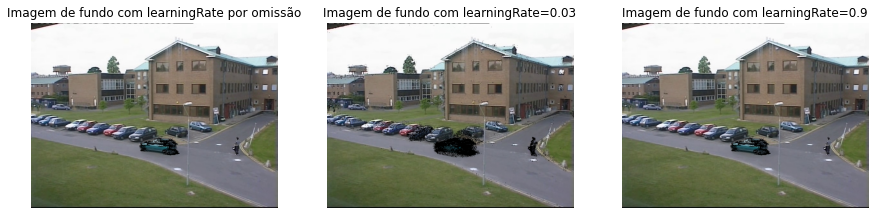

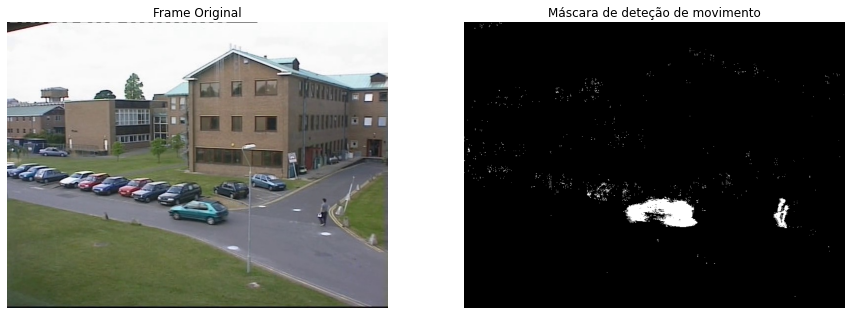

In [7]:
# Variação do learningRate
object_detector = cv2.createBackgroundSubtractorKNN()
masks = [object_detector.apply(frame) for frame in frames[:6]]

object_detector2 = cv2.createBackgroundSubtractorKNN()
masks2 = [object_detector2.apply(frame, learningRate=0.03) for frame in frames[:6]]
object_detector3 = cv2.createBackgroundSubtractorKNN()
masks3 = [object_detector3.apply(frame, learningRate=0.9) for frame in frames[:6]]
plot_imgs(1, 3, [['Imagem de fundo com learningRate por omissão', + \
cv2.cvtColor(object_detector.getBackgroundImage(),cv2.COLOR_BGR2RGB)], ['Imagem de fundo com learningRate=0.03', + \
cv2.cvtColor(object_detector2.getBackgroundImage(),cv2.COLOR_BGR2RGB)], ['Imagem de fundo com learningRate=0.9', + \
cv2.cvtColor(object_detector3.getBackgroundImage(),cv2.COLOR_BGR2RGB)]])

frame_mask = masks[5]

frame_ori = cv2.cvtColor(frames[5], cv2.COLOR_BGR2RGB)
plot_imgs(1, 2, [['Frame Original', frame_ori], ['Máscara de deteção de movimento', frame_mask]])

### Median Blur
Utilizou-se o _Median Blur_ para remover o ruído existente na máscara. Este *blur*, para um dado pixel, analisa os vizinhos que o rodeiam e irá usar a mediana destes para lhe ser atribuido. Realizaram-se vários testes com diferentes parâmetros para se obter uma imagem limpa só com os contornos pretendidos, como se pode observar abaixo.

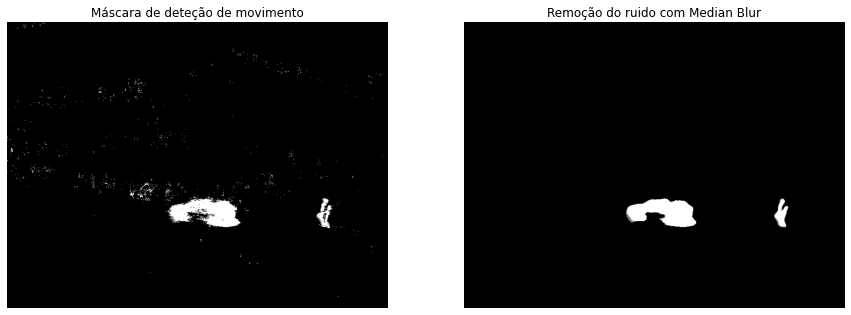

In [8]:
frame_median = cv2.medianBlur(frame_mask, 9)

plot_imgs(1, 2, [['Máscara de deteção de movimento', frame_mask], ['Remoção do ruido com Median Blur', frame_median]])

### Canny
Para delimitar apenas os contornos dos objetos, existem algoritmos que se baseiam no gradiente das imagens. Alguns exemplos destes operadores são o Sobel, ou o Prewitt. Escolheu-se utilizar o algoritmo *Canny*, visto que este aplica um filtro Gaussiano para suavizar a imagem e remover o ruído, encontra os gradientes de intensidade da imagem, aplica-lhes _threshold_ 
e encontra os contornos fortes da imagem. Para este método funcionar corretamente, é necessário que os objetos tenham os contornos fechados para não haver irregularidades. 

O valor de 210 para o _threshold_ não foi escolhido com nenhum critério específico, dado as regiões ativas já estarem com valores de intensidade mais elevados que os inativos na máscara.

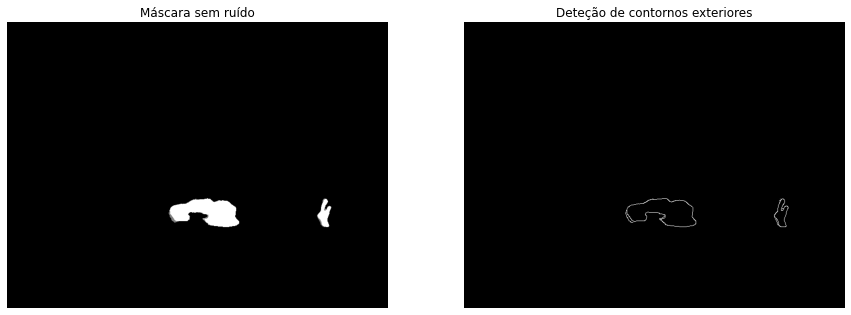

In [9]:
frame_canny = cv2.Canny(frame_median, 210, 255)

plot_imgs(1, 2, [['Máscara sem ruído', frame_median], ['Deteção de contornos exteriores', frame_canny]])

<a name="operadores"></a> 
## 3.3. Aplicação de operadores morfológicos
Os operadores morfológicos são operações que permitem remover imperfeições em imagens segmentadas, mais vulgarmente sobre imagens binárias. Estes precisam de dois argumentos, a imagem e o elemento estruturante (ou *kernel*) que irá decidir a natureza da operação.

Estes operadores são úteis para remover ruído e melhorar os contornos dos objetos para, posteriormente, ser possível a realização de uma correta caracterização dos objetos em movimento.

### Close
O fecho trata-se de uma dilatação seguida de uma erosão. Tal como o nome indica, é útil para fechar os contornos, suavizando a sua curvatura, e pequenos espaços que possam existir no interior dos objetos.

Então, para suavizar os contornos dos objetos de forma a facilitar a identificação dos objetos, aplicou-se o operador morfológico de fecho (_close_), tal se pode observar nas figuras abaixo.

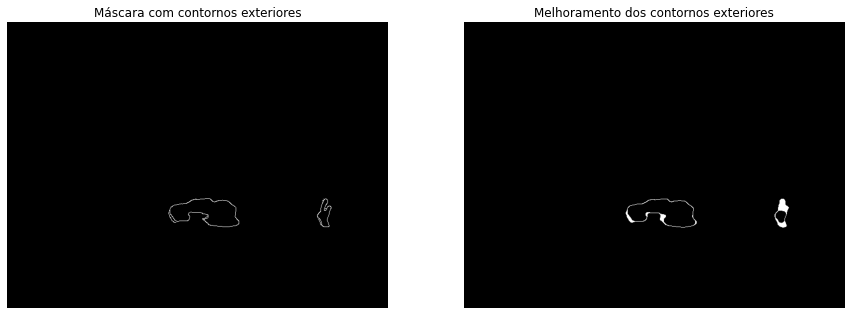

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12, 12), (-1, -1))
frame_closing = cv2.morphologyEx(frame_canny, cv2.MORPH_CLOSE, kernel)

plot_imgs(1, 2, [['Máscara com contornos exteriores', frame_canny], ['Melhoramento dos contornos exteriores', frame_closing]])

<a name="regioesativas"></a> 
## 3.4. Deteção de regiões ativas
Tendo já os contornos bem definidos, é necessário aplicar um algoritmo de deteção de contornos. A biblioteca _OpenCV_ possui o método `findContours()`, com um modo de deteção dos contornos exteriores, que eram os pretendidos, e passa por aplicar o algoritmo de deteção de contornos de Suzuki. Este método retorna então todos os contornos externos existentes numa imagem, bem como propriedades de cada um dos mesmos. Neste caso, para efeitos de visualização, cada contorno será delimitado por um retângulo verde, como se pode observar nas figuras abaixo.

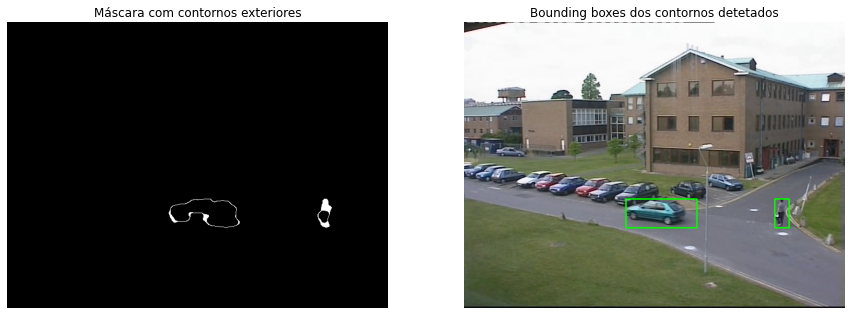

In [11]:
contours, _ = cv2.findContours(frame_closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
frame_ori_copy = frame_ori.copy()

for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    cv2.rectangle(frame_ori_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

plot_imgs(1, 2, [['Máscara com contornos exteriores', frame_closing], ['Bounding boxes dos contornos detetados', frame_ori_copy]])

<a name="classificacao"></a> 
## 3.5. Extração de características e classificação das regiões
De modo a classificar os objetos detetados, teve-se em conta a área dos contornos e o tamanho dos retângulos que melhor se encaixam no contorno (*bounding boxes*). Utilizando um classificador em árvore e realizando vários testes, determina-se que só são identificados objetos cuja área do contorno seja superior a 400. As *bounding boxes* em que a razão entre a largura e a altura seja superior a 1.2, serão identificadas como "Pessoa", se a sua largura for maior que a altura, serão identificadas como "Carro" e as restantes situações como "Outro".

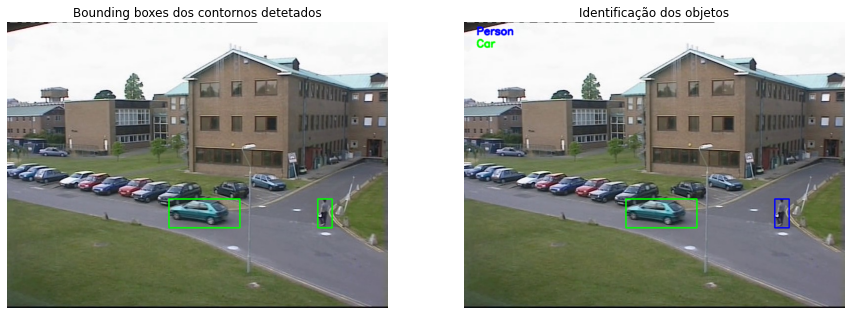

In [12]:
classes = ['Person', 'Car', 'Other']
classColor = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]

for contour in contours:
    area = cv2.contourArea(contour)
    (x, y, w, h) = cv2.boundingRect(contour)
    
    if area > 400:
        if h / w > 1.2:
            cv2.putText(frame_ori, classes[0], (25, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, classColor[0], 2, cv2.LINE_AA)
            cv2.rectangle(frame_ori, (x, y), (x + w, y + h), classColor[0], 2)
        elif w > h:
            cv2.putText(frame_ori, classes[1], (25, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, classColor[1], 2, cv2.LINE_AA)
            cv2.rectangle(frame_ori, (x, y), (x + w, y + h), classColor[1], 2)
        else:
            cv2.putText(frame_ori, classes[2], (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 0.7, classColor[2], 2, cv2.LINE_AA)
            cv2.rectangle(frame_ori, (x, y), (x + w, y + h), classColor[2], 2)

plot_imgs(1, 2, [['Bounding boxes dos contornos detetados', frame_ori_copy], ['Identificação dos objetos', frame_ori]])

<a name="trajetorias"></a> 
## 3.6. Criação das trajetórias dos objetos detetados
Para se obter as trajetórias dos objetos, começa-se por determinar se são regiões de interesse, ou seja, se a área da _bounding box_ tem um valor superior ao limite que determinámos para se possa considerar um elemento como sendo de interesse. De seguida, identifica-se o seu centróide e atribui-se-lhe um índice. Para se evitar a atribuição de índices diferentes ao mesmo objeto quando este deixa de ser detetado por alguns momentos, a última posição dos contornos detetados é guardada e foi definida uma margem para que, se um contorno identificado estiver dentro dessa distância de algum dos anteriormente guardados, é porque é o mesmo.

A trajetória de cada elemento é guardada conforme o identificador que lhe está atribuído, e é composta pela posição central do contorno inferior da _bounding box_ da região, em _frames_ sucessivas. É desenhada com uma linha a unir cada posição da trajetória e as cores são escolhidas aleatoriamente para cada identificador.

De forma a não serem representadas trajetórias de elementos que já não estão a ser detetados na imagem, à medida que os elementos saem do campo de visão da câmera, ou que ficam imóveis durante um determinado período de tempo, as suas trajetórias vão sendo eliminadas.

<a name="resultados"></a> 
# 4. Resultados Experimentais
Neste ponto, estão os resultados de diferentes testes ao funcionamento da aplicação.

<div align="center" style="margin: 20px;">
  <img src="https://cdn.discordapp.com/attachments/433020763428093962/810550157921091614/Screenshot_4.png" width="80%" style="display: inline;"/>
</div>
<div align="center" style="margin: 20px;">
  <img src="https://cdn.discordapp.com/attachments/433020763428093962/810550160282091540/Screenshot_5.png" width="80%" style="display: inline;"/>
</div>
<div align="center" style="margin: 20px;">
  <img src="https://cdn.discordapp.com/attachments/433020763428093962/810550162459066368/Screenshot_6.png" width="80%" style="display: inline;"/>
</div>
<div align="center" style="margin: 20px;">
  <img src="https://cdn.discordapp.com/attachments/433020763428093962/810550164799619113/Screenshot_7.png" width="80%" style="display: inline;"/>
</div>
<div align="center" style="margin: 20px;">
  <img src="https://cdn.discordapp.com/attachments/433020763428093962/810550166263824444/Screenshot_8.png" width="80%" style="display: inline;"/>
</div>

<a name="conclusoes"></a> 
# 5. Conclusões

Pode-se concluir que foram cumpridos os objetivos propostos, os objetos estão a ser corretamente identificados e classificados e a sua trajetória é assinalada. Pôde-se verificar a influência da velocidade de aprendizagem de imagens de fundo, do uso da filtragem de mediana, da deteção de contornos pelo algoritmo de Canny e da aplicação de operadores morfológicos em que dos quais o fecho foi o que nos proporcionou o resultado pretendido. 

Conseguimos ainda compreender e identificar diversos problemas que podem surgir deste tipo de aplicações, de videovigilância e deteção de movimento, tais como: a sobreposição de vários objetos simultaneamente em movimento, a imobilização momentânea de elementos e a presença de objetos em movimento residuais e/ou indesejados.